# Introduction

- Introduce MCMC algorithm
- - Shi Feng simulator
- PyMC
- - Applying it to simple models
- - - arviz to plot, summarize
- - Using draw to debug, visualize components
- - Applying it to mixture models
- - - Introduce Dirichlet
- - - rhat
- - - Introduce regularizing priors
- - Prior outcome distributions
- - - Divergences



# The Monte Carlo Markov Chain (MCMC)

Last time, we notice that the grid approximation algorithm starts to collapse when try to fit models with three or more parameters. We have a dilemma: either we use an extremely fine-grain to approximate the posterior and blast our computation time through the roof. Or, we use an course-grain and run the risk of missing the most important features of the posterior.

One problem with grid approximation is that we spend a lot of time computing in pretty boring regions of the posterior. Take a look at this posterior. Much of the space is basically flat at 0 or nearly 0 posterior probability.

!()[]



I'll introduce monte carlo markov chain with a parable. Imagine a skateboard park with a massive bowl at the center. The skateboard park has been carefully measured so we have a grid of x and y coordinates that covers each point in the park. Also imagine there is no friction. A skateboarder rides around the bowl for an hour or so. Every few seconds, an aerial drone stationed directly above the bowl takes a snapshot of the skateboarder. Thousands of snapshots are recorded. In each one, we record the x and y coordinates of the skateboarder. After the hour is over, we compile a list of all the x and y coordinates.

In this parable, the depth of the bowl represents areas with high likelihood. The location of the skateboard with respect to x and y represents two different parameter values, perhaps `p` is on one axis and `d` is on another. It turns out that the frequency distribution of locations will perfectly correspond to the depth of the bowl. Or, simply, the skateboarder will get their picture taken most often when they are in the center of the bowl. They will get their picture taken fairly often in the region between the edge and the center. And they will get their picture taken least often at the rim. Why? Well, they are usually only at the rim for a split second before they turn around and go back. But quite often they are flying through the center of the bowl. The laws of gravity and momentum help ensure this is true. Here you can watch a particular version of the MCMC (the Hamiltonian) algorithm working on a bowl shaped distribution.

https://chi-feng.github.io/mcmc-demo/app.html?algorithm=HamiltonianMC&target=standard

Okay how does this wacky parable help us? Well, it means we only need a finite number of snapshots to get a good approximation of the posterior distribution. As we add more parameters to model, the number of snapshots doesn't grow out of control. Instead of exploring every possible combination of values, we spend more of our time looking at the interesting values (those close to the center). But instead of only looking for the best, we also spend some time exploring the values at the edges (to get a sense of uncertainty).

Designing and implementing monte carlo markov chain algorithms is really tough. So we've handed that work off to a package called pymc. Here is how to use it:

# PyMC

We import it like this:

In [ ]:
import pymc as pm

## Simple binomial problems in pymc

We feed pymc our prior and our likelihood function using a `with pm.Model as NAME_OF_MODEL`. Notice the indentation. The `with` structure is a way of grouping a bunch of information under a single object, this time called `model_0`.

In [ ]:
with pm.Model() as model_0:
    
    # --priors--
    # uniform is another name for a flat prior
    # that assigns equal probability to every p in
    # between 0 and 1.
    
    p = pm.Uniform('p',lower=0,upper=1)
    
    # --likelihood--
    # this the pymc syntax equivalent for stats.binom
    # n is still n
    # p is still p
    # but k has been replaced with 'observed'
    
    y = pm.Binomial('y',n=8,p=p,observed=6)

You can run the cell with just this information in it to see if everything is well defined. Notice that this is the same Bayesian estimation of the lady tasting tea from before. But we only really need two lines of code to express it: the prior and the likelihood. No need to define a grid. No need to manually normalize things.

In [ ]:
with model_0:
    # estimation algorithm
    # pm.sample() just uses all the default settings
    # the package automatically detects which
    # estimation algorithm will work for your model
    # and tunes the algorithm for best performance
    # rarely, if ever, should use anything but the default settings
    
    trace = pm.sample()

Once we check to make sure our model is well-defined, we can do `trace = pm.sample()`. `trace` is the name of the object we store all the information into once we want to analyze the results later. `pm.sample()` is the command to activate the monte carlo markov chain. It will usually call it "NUTS" which is a sub-class of monte carlo markov chain that works great on nearly every type of Bayesian problem.

Finally, we have a plotting package called arviz which works well for Bayesian models. `plot_posterior` is the main command you'll want.

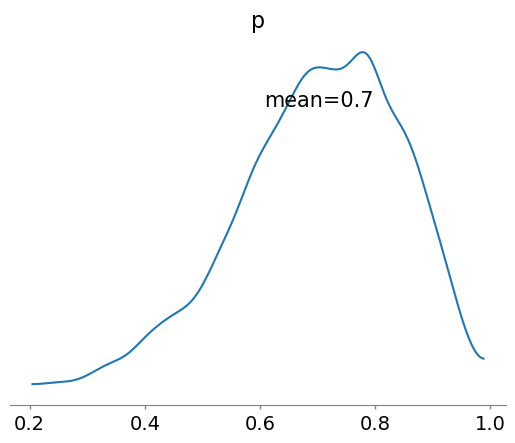

In [ ]:
import arviz as az

az.plot_posterior(trace,hdi_prob='hide');

This should look familiar - it's the same posterior distribution chart we got from the grid approximation algorithm.

## Adjusting priors

We can easily adjust our priors using this software. Here is an example.

In [ ]:
with pm.Model() as model_1:
    
    # you can play around with different priors
    # I switched out the uniform distribution for a beta
    # that puts more credibility toward medium values of p
    # and less credibility to extreme values of p
    
    p = pm.Beta('p',alpha=3,beta=3)
    
    y = pm.Binomial('y',n=8,p=p,observed=6)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


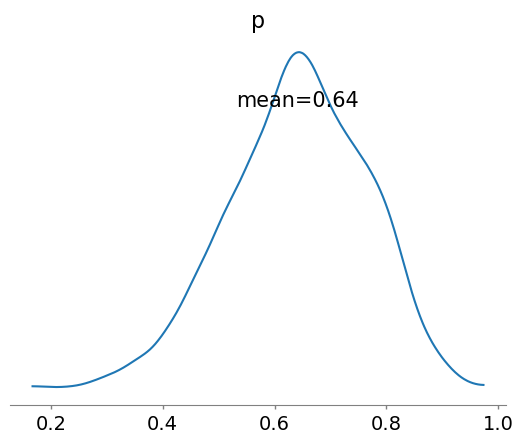

In [ ]:
az.summary(trace);

# Mixture models

In [ ]:
url = "https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/Asch_experiment_1_data"
# url = r"C:\Users\dsaun\github_projects\cogs-303\Asch_experiment_1_data" # local path - ignore this

df = pd.read_csv(url)
df_treatment = df[df.treatment == 1]
mistakes_treatment = df_treatment.mistakes.values

In [ ]:
with pm.Model() as model_2:

    # mixture weights

    w = pm.Dirichlet('w',[1,1])

    # mixture components

    p0 = pm.Beta('p0',1,1) # independent component
    p1 = pm.Beta('p1',1,1) # conformist component
    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]

    # likelihood

    y = pm.Mixture('error',w=w,comp_dists=components,observed=mistakes_treatment)

pm.draw(y)

## The Dirichlet distribution

In [ ]:
with pm.Model() as explore_dirichlet:
    w = pm.Dirichlet('w',[1,1])

pm.draw(w)

In [ ]:
with pm.Model() as explore_dirichlet:
    w = pm.Dirichlet('w',[1,1,1])

pm.draw(w)

In [ ]:
with pm.Model() as explore_dirichlet:
    w = pm.Dirichlet('w',[100,100])

draws = pm.draw(w,draws=1000)
plt.hist(draws)

## Markov Chain Convergence

In [ ]:
with model_2:
    trace_2 = pm.sample()

In [ ]:
az.summary(trace_2)

## Regularizing priors

In [ ]:
rate = 0.5
n = 12

independents_grid = np.linspace(0,1,100)
conformist_grid = np.linspace(0,1,100)

ind_prior = stats.beta(0.5,2).pdf(independents_grid)
ind_prior = ind_prior / sum(ind_prior)

con_prior = stats.beta(2,0.5).pdf(conformist_grid)
con_prior = con_prior / sum(con_prior)

In [ ]:
posterior_table = []

for row in range(100):

    # row is a counter from 0 to 99

    posterior_row = []

    for column in range(100):

        # we use row to index which parameter 
        # we'll need in the likelihood calculation
        # and which prior we'll need for the posterior
        # calculation.

        p1 = independents_grid[row]
        p2 = conformist_grid[column]
        prior1 = ind_prior[row]
        prior2 = con_prior[column]

        likelihood = mixture_likelihood(mistakes_treatment,rate,p1,p2,n)

        posterior = likelihood * prior1 * prior2
        posterior_row.append(posterior)

    posterior_table.append(posterior_row)

# convert to numpy array

posterior_table = np.array(posterior_table)

# normalize the posterior by finding an expectation

posterior_table = posterior_table / np.sum(posterior_table)

# package it into a dataframe to make visualization easier

posterior_distribution = pd.DataFrame(posterior_table,columns=independents_grid,index=conformist_grid)

In [ ]:
# You don't need to spend time learning this bit of code
# it is unnecessarily complex
# I've put it in the lecture for illustrative purposes

fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(10,10))

x_coord, y_coord = np.meshgrid(independents_grid,conformist_grid)

surf = ax.plot_surface(x_coord, y_coord, posterior_table)
plt.ylabel("Independents error rate")
plt.xlabel("Conformist error rate");

In [ ]:
with pm.Model() as model_3:

    # mixture weights

    w = pm.Dirichlet('w',[1,1])

    # mixture components

    p0 = pm.Beta('p0',0.5,2) # independent component
    p1 = pm.Beta('p1',2,0.5) # conformist component
    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]

    # likelihood

    y = pm.Mixture('error',w=w,comp_dists=components,observed=mistakes_treatment)

    trace_3 = pm.sample()

## Understanding the model ouput

In [ ]:
with model_3:
    spp = pm.sample_posterior_predictive(trace_3)

In [ ]:
spp

In [ ]:
for i in range(4):
    predict = spp.posterior_predictive.error.values[i].flatten()
    plt.hist(predict,alpha=0.1,color="tab:blue")